# Titanic Survival:  Data Analysis 

In [88]:
import pandas as pd 
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from matplotlib import cm as colorm
from matplotlib import patheffects as path_effects

from sklearn import linear_model, preprocessing
from sklearn.feature_selection import RFECV

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, \
    precision_score, recall_score, classification_report

from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, \
    BaggingRegressor, ExtraTreesClassifier, ExtraTreesRegressor, AdaBoostRegressor, \
    GradientBoostingRegressor, RandomForestClassifier, RandomForestRegressor

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

"Cross-sectional drawing showing ice penetrating the double bottom of the Titanic." [here](http://bit.ly/29YeBu8) 

![](http://i586.photobucket.com/albums/ss306/realphotos/TITANIC/5.jpg)

In [89]:
## !psql -h dsi.c20gkj5cvu3l.us-east-1.rds.amazonaws.com -p 5432 -U dsi_student titanic
## password: gastudents
## my_lil_engine = create_engine('postgresql://\
## dsi_student:gastudents@dsi.c20gkj5cvu3l.us-east-1.rds.amazonaws.com/titanic')
## df = pd.read_sql('SELECT * FROM train', my_lil_engine)
## df.to_csv('titanic.csv', encoding='utf-8')

Run this cell to load the dataframe obtained directly above:

In [90]:
titanic = pd.read_csv('assets/titanic.csv')

titanic.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [91]:
titanic.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [92]:
len(titanic)

891

Gets rid of "PassengerId" if it's index-like:

In [93]:
if list(titanic['PassengerId']) == range(1, len(titanic) + 1, 1):
    print 'PassengerId is index offset by 1.'
else:
    print titanic['PassengerId'].describe()

PassengerId is index offset by 1.


In [94]:
titanic['Sex'].value_counts() 

male      577
female    314
Name: Sex, dtype: int64

In [95]:
titanic['Survived'].value_counts() # will be target variable

0    549
1    342
Name: Survived, dtype: int64

In [96]:
titanic['Survived'] = titanic['Survived'].apply(lambda x: str(x))

In [97]:
titanic['Pclass'].value_counts() # ranked categorical; getting dummies loses ranked aspect

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [98]:
missing_ages = len(titanic) - len(titanic[titanic['Age'] > 0])
perc = (len(titanic) - len(titanic[titanic['Age'] > 0])) / float(len(titanic))
print 'There are %s age values missing from the dataframe' %missing_ages + ' (%s percent).' \
%(round(perc, 3)*100)

There are 177 age values missing from the dataframe (19.9 percent).


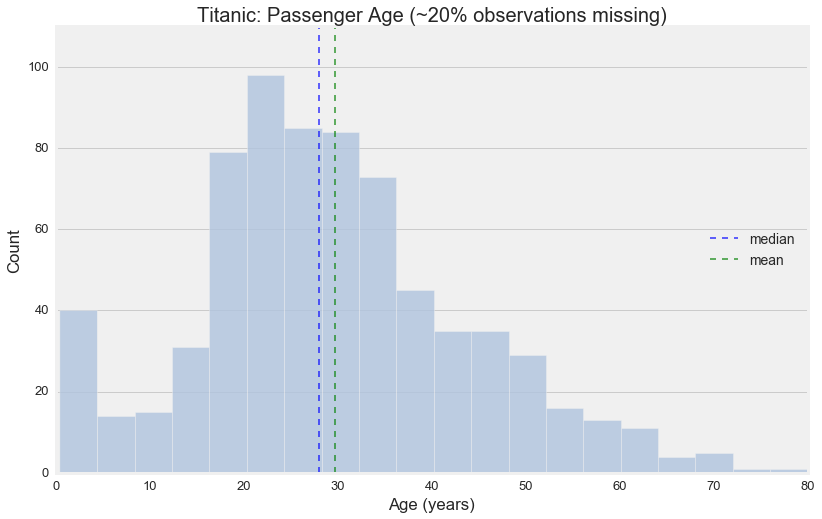

In [99]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

titanic_age = titanic[titanic['Age'] > -0.1]
age_hist = plt.hist(titanic_age['Age'], color = 'lightsteelblue', alpha = 0.8, bins = 20)
plt.axvline(titanic_age['Age'].median(), color='b', linestyle='dashed', linewidth=1.5, \
            label = 'median', alpha = 0.8)
plt.axvline(titanic_age['Age'].mean(), color='g', linestyle='dashed', linewidth=1.5, \
            label = 'mean', alpha = 0.8)

plt.title('Titanic: Passenger Age (~20% observations missing)', fontsize = 20)

plt.ylabel('Count')
plt.ylim([0, 110])
plt.yticks(range(0, 120, 20), fontsize = 13)

plt.xlabel('Age (years)')
plt.xlim([0, max(titanic_age['Age'])])
plt.xticks(range(0, 90, 10), fontsize = 13)

plt.legend(loc='center right', fontsize = 14)

plt.grid(which='major', axis = 'x')

plt.show()

In [100]:
titanic['SibSp'].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [101]:
titanic['Parch'].value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [102]:
titanic['Ticket'].value_counts()[0:10]

CA. 2343        7
347082          7
1601            7
347088          6
CA 2144         6
3101295         6
382652          5
S.O.C. 14879    5
PC 17757        4
4133            4
Name: Ticket, dtype: int64

In [103]:
titanic['Cabin'].head(10)

0     NaN
1     C85
2     NaN
3    C123
4     NaN
5     NaN
6     E46
7     NaN
8     NaN
9     NaN
Name: Cabin, dtype: object

I inspected these variables in-depth and have decided to leave them out for the purpose of this regression analysis.

In [104]:
titanic.drop(['Ticket', 'Cabin'], axis = 1, inplace = True)

### **Let's clean the data set and generate some variables of potential interest:**

In [105]:
list(titanic.columns)

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Embarked']

In [106]:
titanic['title'] = [x.split(', ')[1].split(' ')[0].strip('.') for x in titanic['Name']]

In [107]:
titanic['title'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Col           2
Mlle          2
Jonkheer      1
Ms            1
Lady          1
the           1
Don           1
Mme           1
Capt          1
Sir           1
Name: title, dtype: int64

In [108]:
title_dict = {
    "Capt"      :  "Officer",
    "Col"       :  "Officer",
    "Major"     :  "Officer",
    "Jonkheer"  :  "Royalty",
    "Don"       :  "Royalty",
    "Sir"       :  "Royalty",
    "Dr"        :  "Officer",
    "Rev"       :  "Officer",
    "the"       :  "Royalty", ## Countess
    "Mme"       :  "Mrs",
    "Mlle"      :  "Miss",
    "Ms"        :  "Mrs",
    "Mr"        :  "Mr",
    "Mrs"       :  "Mrs",
    "Miss"      :  "Miss",
    "Master"    :  "Master",
    "Lady"      :  "Royalty"
}

titanic['title'] = titanic['title'].apply(lambda x: title_dict[x])

In [109]:
titanic['title'].value_counts()

Mr         517
Miss       184
Mrs        127
Master      40
Officer     18
Royalty      5
Name: title, dtype: int64

In [110]:
titanic['Fare'] = titanic['Fare'].apply(lambda x: round(x, 2))

In [111]:
def dummies(my_df, cols):
    for column in cols:
        my_df = pd.concat([my_df.drop(column[0], axis = 1), pd.get_dummies(my_df[column[0]], \
                    drop_first = True, prefix = column[1])], axis = 1)
    return my_df

In [112]:
titanic.columns

Index([u'PassengerId', u'Survived', u'Pclass', u'Name', u'Sex', u'Age',
       u'SibSp', u'Parch', u'Fare', u'Embarked', u'title'],
      dtype='object')

In [113]:
cols = [('Pclass', 'class'), ('Sex', None), ('Embarked', 'embark'), ('title', None)]

titanic = dummies(titanic, cols)

In [114]:
titanic.head(1)

,PassengerId,Survived,Name,Age,SibSp,Parch,Fare,class_2,class_3,male,embark_Q,embark_S,Miss,Mr,Mrs,Officer,Royalty
0,1,0,"Braund, Mr. Owen Harris",22.0,1,0,7.25,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


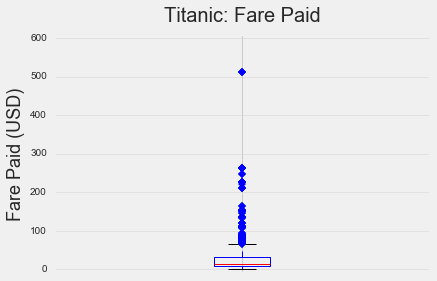

In [120]:
fig, ax1 = plt.subplots()

plt.boxplot(titanic['Fare'], 0, 'gD')

ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)

ax1.set_axisbelow(True)
ax1.set_title('Titanic: Fare Paid', y =1.03, fontsize = 20)
ax1.set_ylabel('Fare Paid (USD)', fontsize = 18)

numBoxes = 1
ax1.set_xlim(0.5, numBoxes + 0.5)
ax1.set_ylim(-10, 610)
xtickNames = plt.setp(ax1, xticklabels=[''])
plt.setp(xtickNames, fontsize=14)

plt.show()

Which passengers are paying over $300?

In [121]:
titanic[titanic['Fare'] > 300]

,PassengerId,Survived,Name,Age,SibSp,Parch,Fare,class_2,class_3,male,embark_Q,embark_S,Miss,Mr,Mrs,Officer,Royalty
258,259,1,"Ward, Miss. Anna",35.0,0,0,512.33,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
679,680,1,"Cardeza, Mr. Thomas Drake Martinez",36.0,0,1,512.33,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
737,738,1,"Lesurer, Mr. Gustave J",35.0,0,0,512.33,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


They traveled together (ticket info shows); maybe $512.33 is total Fare?  We could divide by three or just take them out.  Let's remove them, because they are obviously outliers even if Fare is correct:

In [50]:
titanic = titanic[titanic['Fare'] < 300]
titanic.reset_index(drop = True, inplace = True)

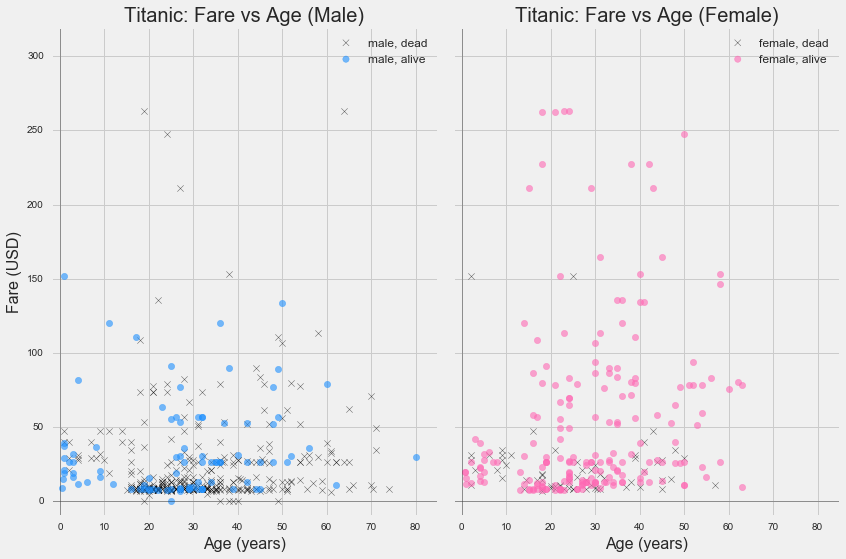

In [62]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

f.set_figwidth(12)
f.set_figheight(8)

gender_dict = {
    1 : 'male',
    0 : 'female'
}

survival_dict = {
    '0' : ['x', 'dead'],
    '1' : ['o', 'alive']
}

color_dict = {
    '0' : ['black', 'black'],
    '1' : ['hotpink', 'dodgerblue']
}

plot_dict = {
    'axis' : [ax1, ax2],
    'title' : ['Titanic: Fare vs Age (Male)', 'Titanic: Fare vs Age (Female)'],
}

for i in [0, 1]:

    axis = plot_dict['axis'][i]    
    axis.set_title(plot_dict['title'][i], fontsize = 20, y = 1.0)
    axis.set_ylim([-10, 320])
    axis.set_yticks(range(0, 350, 50))
    ax1.set_ylabel('Fare (USD)', fontsize = 16)
    axis.set_xlim([-2, 85])
    axis.set_xticks(range(0, 90, 10))
    axis.set_xlabel('Age (years)', fontsize = 16)
    axis.axhline(0, color = 'black', linewidth = 1, alpha = 0.3)
    axis.axvline(0, color = 'black', linewidth = 1, alpha = 0.3)

for gender in [(1, ax1), (0, ax2)]:
    for survival in ['0', '1']:
        gender[1].scatter(
            titanic[(titanic['male'] == gender[0]) & (titanic['Survived'] == survival)]['Age'],
            titanic[(titanic['male'] == gender[0]) & (titanic['Survived'] == survival)]['Fare'],
            color = color_dict[survival][gender[0]], alpha = 0.6, s = 40,
            marker = survival_dict[survival][0],
            label = '{}, {}'.format(gender_dict[gender[0]], survival_dict[survival][1]))
        gender[1].legend(loc = 'best', fontsize = 12)
        
plt.tight_layout()

plt.show()

From this scatterplot, we can see for example young males and well-paying females had relatively high survival rates among passengers included in the data.  It looks like most males who paid no Fare did not survive.  No females paid no Fare.  There were not as many older women as older men, either alive or dead.  The 80 year old man perhaps got helped off because he was so old.  In general, it appears that the proportion of surviving females was higher than that of surviving males.

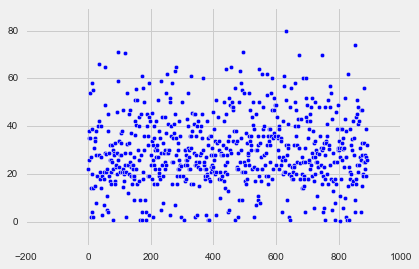

In [56]:
plt.scatter(titanic['PassengerId'], titanic['Age'])

In [59]:
titanic.columns

Index([u'PassengerId', u'Survived', u'Age', u'SibSp', u'Parch', u'Fare',
       u'class_2', u'class_3', u'male', u'embark_Q', u'embark_S', u'Miss',
       u'Mr', u'Mrs', u'Officer', u'Royalty'],
      dtype='object')

TypeError: cannot concatenate 'str' and 'float' objects

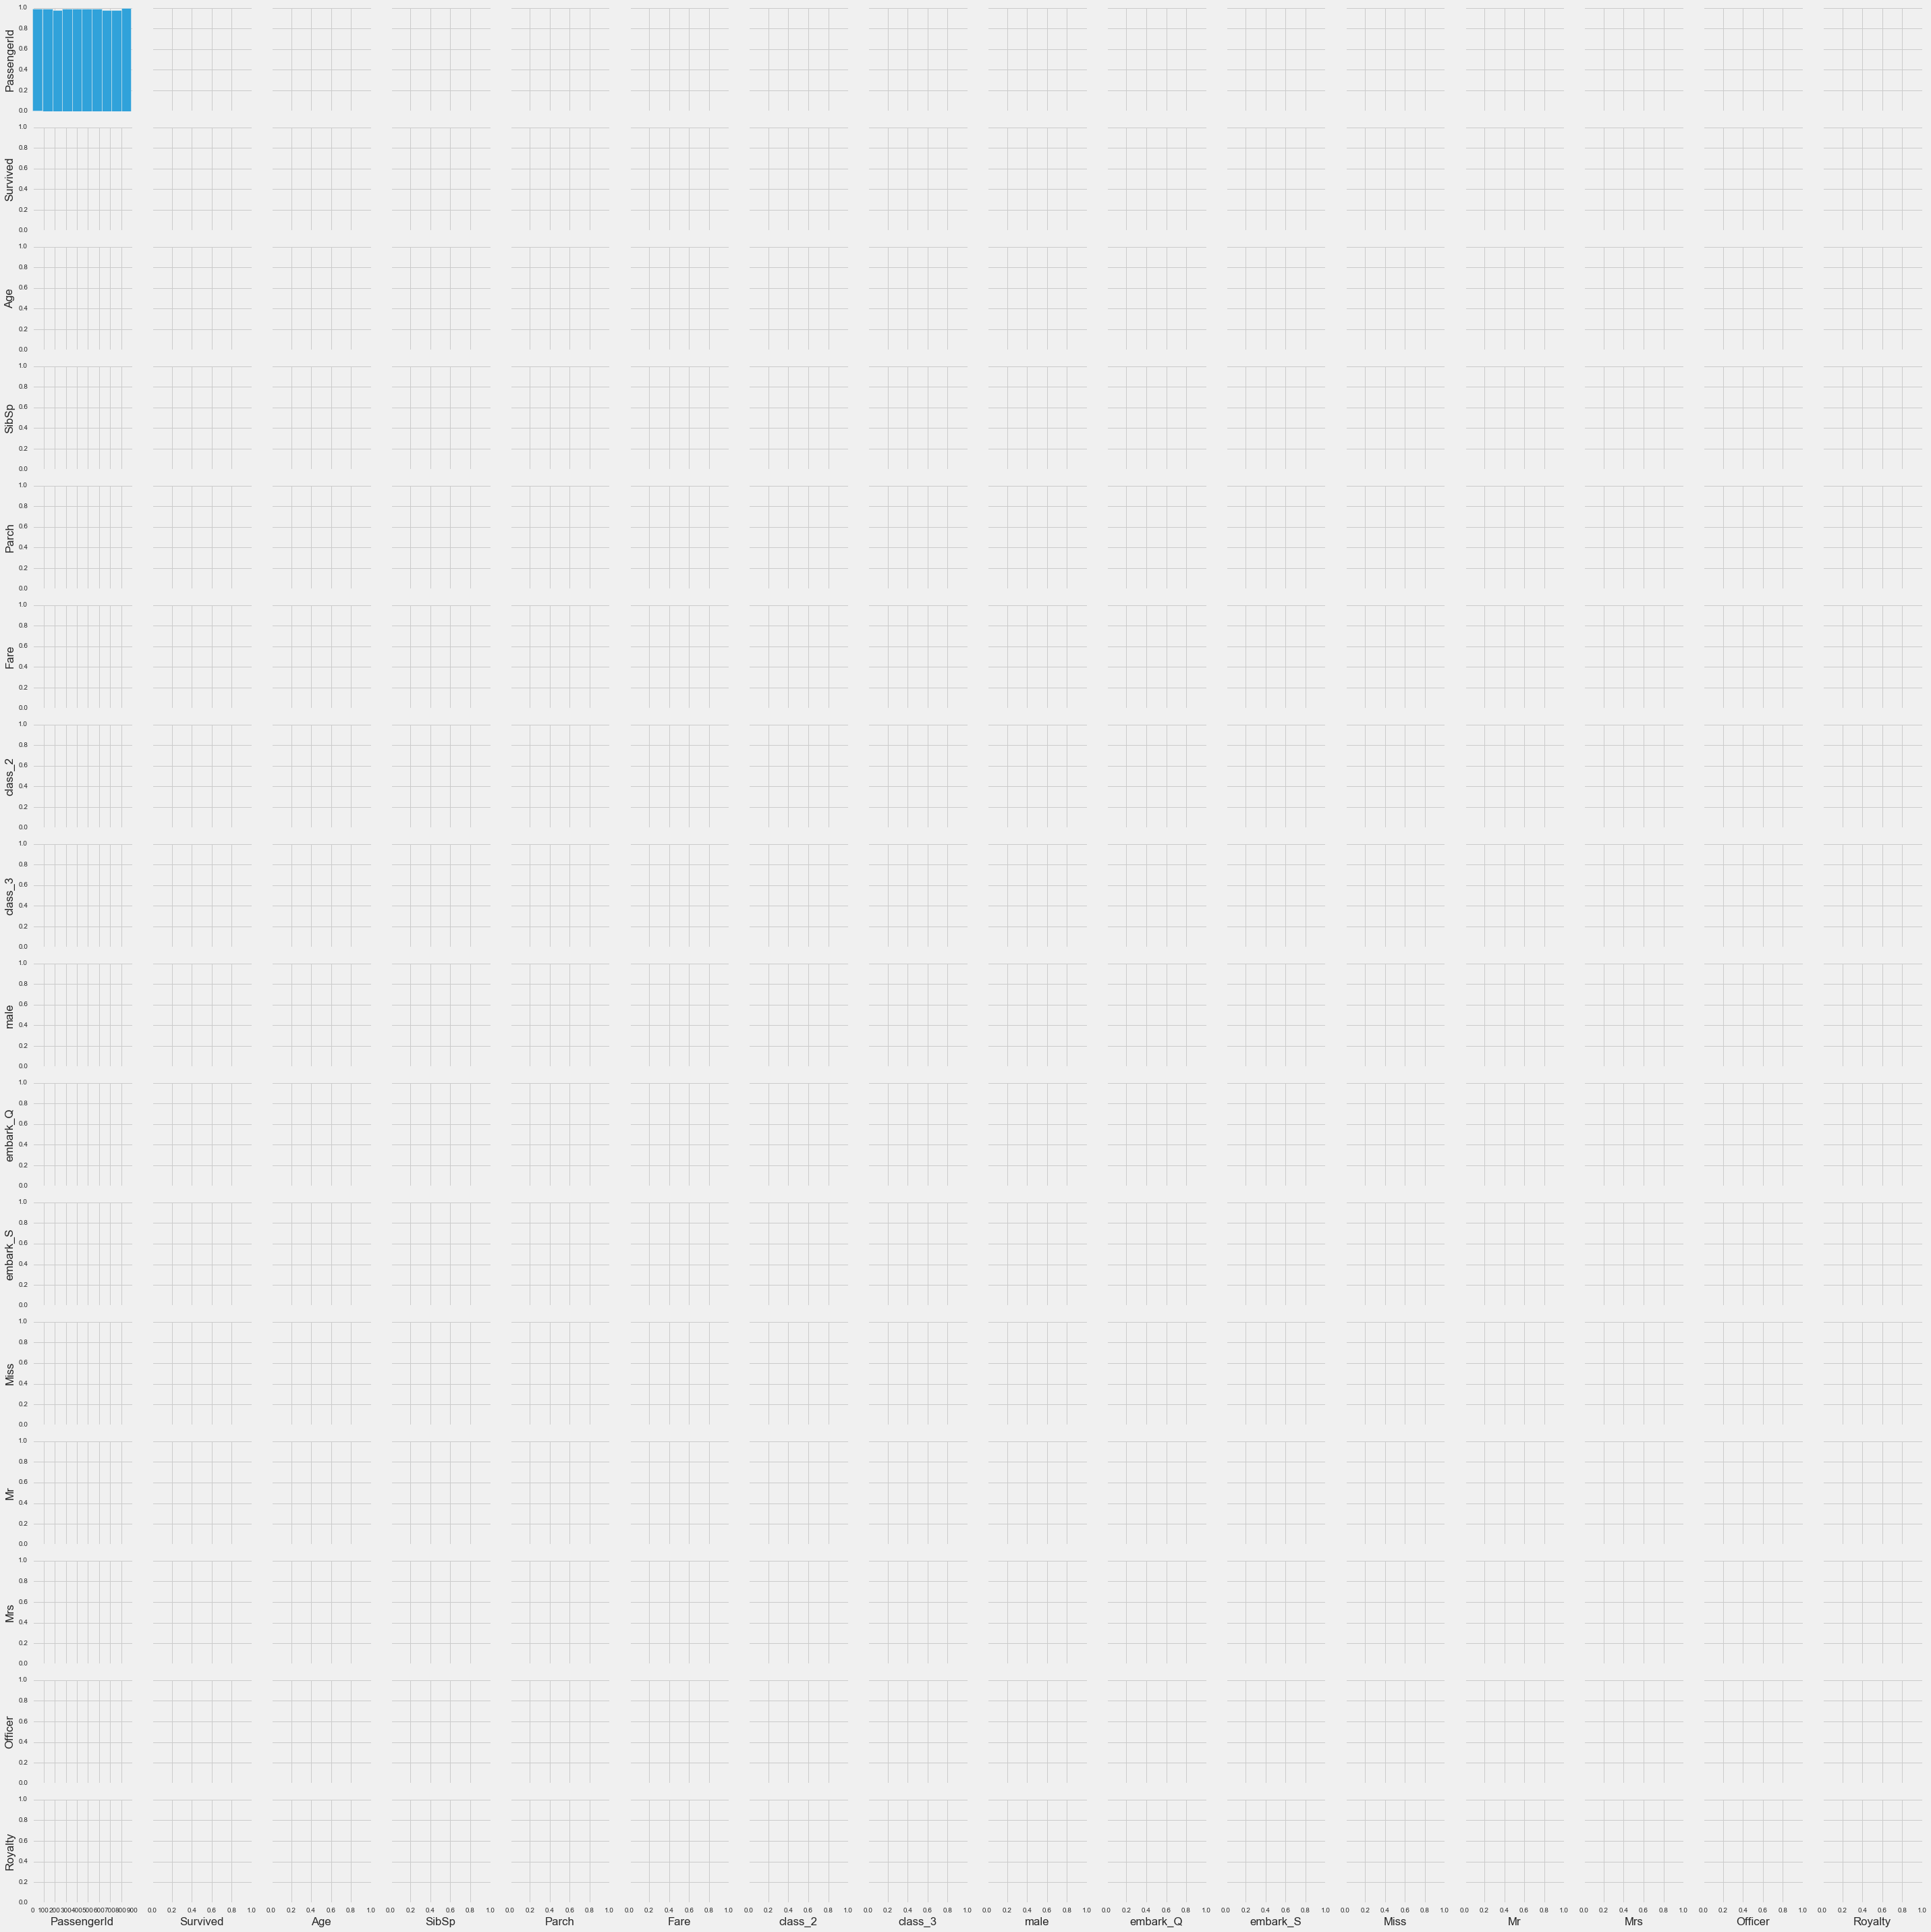

In [58]:
sns.pairplot(titanic)

### Make the model

Run logistic regression without 'age' as a feature since we're missing so many values.

In [54]:
list(titanic.columns)

['PassengerId',
 'Survived',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'class_2',
 'class_3',
 'male',
 'embark_Q',
 'embark_S',
 'Miss',
 'Mr',
 'Mrs',
 'Officer',
 'Royalty']

In [82]:
preX = titanic.drop(['Survived', 'Age'], axis = 1)

X = pd.DataFrame(preprocessing.scale(preX), columns = preX.columns)

y = titanic['Survived']

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

In [85]:
n = 3
plot_colors = []
for i in range(0, 256, 256/n):
    plot_colors.append(colorm.Accent(i))

cv = KFold(3, shuffle=False, random_state = 42)


def do_plot(model, m=1):
    for fold, color in zip(cv, plot_colors):
        X_train = X.iloc[fold[0]]
        X_test  = X.iloc[fold[1]]
        y_train = y.iloc[fold[0]]
        y_test  = y.iloc[fold[1]]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
                
        plt.scatter(y_pred, y_test, color=color)
        plt.plot([8.0,9.5],[8.0,9.5], linewidth = 0.3)
        plt.text(9,9.5, "R^2: "+str(m), fontsize=20)
    return   

### Decision Tree Regressor

In [199]:
dt = DecisionTreeRegressor()

scores = cross_val_score(dt, X_train, y_train, cv=cv)
scores.mean()

-0.084128952216783848

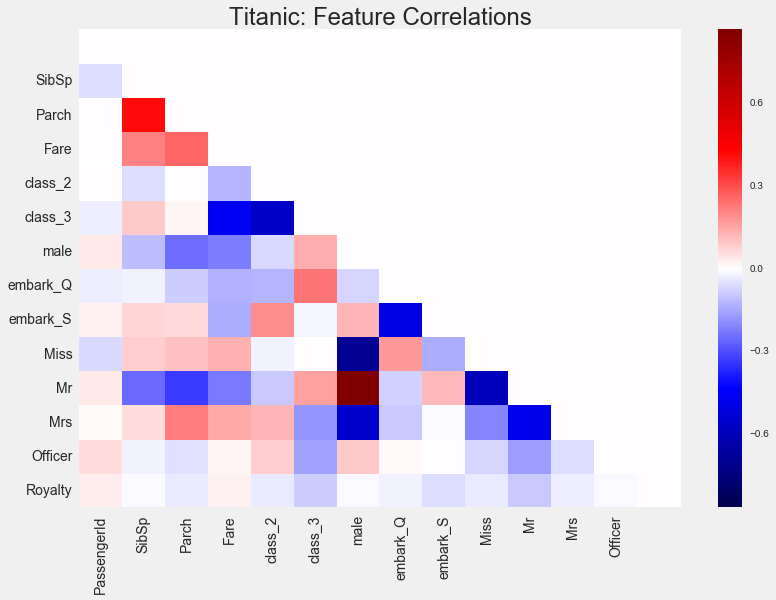

In [154]:
plt.figure(figsize = (12, 8))
corr_mat = np.tril(X.corr(), k=-1)
sns.heatmap(corr_mat, cmap = 'seismic')
plt.title('Titanic: Feature Correlations', fontsize = 24)
plt.xticks(np.arange(0.5, 13.5, 1), X.columns, fontsize = 14, rotation = 90)
plt.yticks(np.arange(0.5, 13.5, 1), list(X.columns)[::-1], fontsize = 14, rotation = 0)
plt.show()

In [156]:
penalty = np.array(['l1', 'l2'])
C = np.array([1, 2, 5, 8, 10, 100, 1000, 10000])

model = linear_model.LogisticRegression(fit_intercept = True, n_jobs = -1)
grid = GridSearchCV(estimator=model, param_grid=dict(C=C, penalty=penalty))
grid.fit(X_train, y_train)
# summarize the results of the grid search
print 'accuracy: %s' %grid.best_score_ 
print grid.best_estimator_

accuracy: 0.816498316498
LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [157]:
selector = RFECV(grid.best_estimator_, step=1, cv=5)
selector.fit(X_train, y_train)
X.columns[selector.support_]

Index([u'SibSp', u'class_3', u'Mr', u'Officer'], dtype='object')

In [158]:
X2 = X[X.columns[selector.support_]]

X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size = 0.33, random_state = 42)

In [159]:
model = linear_model.LogisticRegression(fit_intercept = True, n_jobs = -1)
grid2 = GridSearchCV(estimator=model, param_grid=dict(C=C, penalty=penalty))
grid2.fit(X2_train, y_train)
# summarize the results of the grid search
print 'accuracy: %s' %grid2.best_score_ 
print grid2.best_estimator_

accuracy: 0.814814814815
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [160]:
grid2 = grid2.best_estimator_

grid2.fit(X2_train, y_train)

grid2.coef_

array([[-0.53690028, -0.78263547, -1.4385693 , -0.48267101]])

In [161]:
coefs = pd.DataFrame(grid2.coef_).T
coefs.index = X2.columns
coefs.columns = ['coef']
coefs['abs_coef'] = coefs['coef'].apply(lambda x: abs(x))
coefs = coefs.sort_values(by = 'abs_coef', ascending = False)

coefs

,coef,abs_coef
Mr,-1.438569,1.438569
class_3,-0.782635,0.782635
SibSp,-0.536900,0.536900
Officer,-0.482671,0.482671


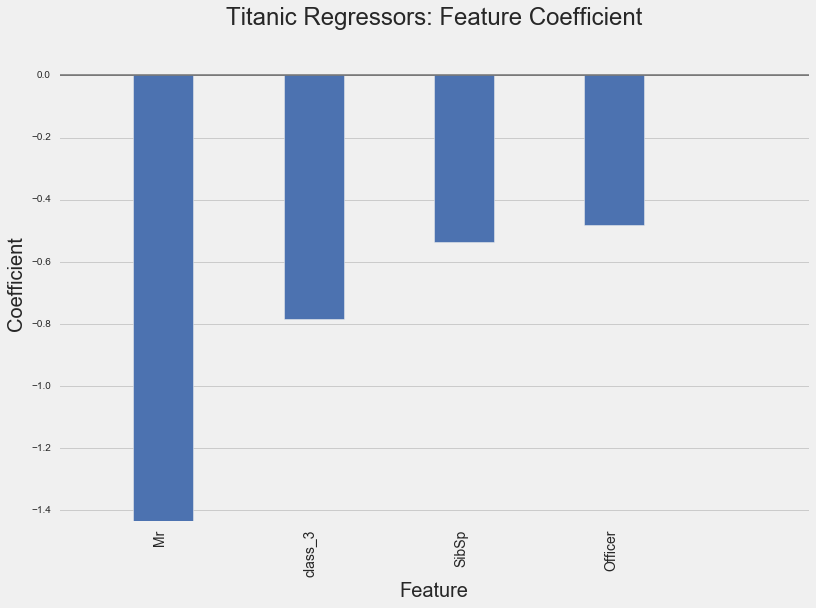

In [162]:
plt.figure(figsize=(12,8))

feature_set = X2
N = len(feature_set.columns)
ind = np.arange(N)    # x locations
width = 0.4       # the width of the bars

plt.bar(ind, coefs['coef'], width)

plt.ylabel('Coefficient', fontsize = 20)
plt.title('Titanic Regressors: Feature Coefficient', fontsize = 24, y = 1.03)
plt.xticks(ind + 0.18, coefs.index, fontsize = 14, rotation = 90)
plt.xlim([-0.5, len(feature_set.columns) + 0.5])
#plt.yticks(np.arange(0, 1.4, 0.2), fontsize = 14)
plt.ylim([min(coefs['coef']), .1])
plt.xlabel('Feature', fontsize = 20)

plt.grid(which='major', axis = 'x')

plt.axhline(0, linewidth = 2, color = 'black', alpha = 0.4)

plt.show()

In [163]:
y_pred = grid2.predict(X2_test)

In [164]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[156,  20],
       [ 27,  91]])

In [165]:
def plot_confusion_matrix(cm, title='Confusion matrix', labels=['Positive','Negative'], \
                          cmap=plt.cm.Blues):
    
    plt.figure(figsize=(12,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, labels, fontsize = 18)
    plt.yticks(tick_marks, labels, rotation = 90, fontsize = 18)
        
    plt.title(title, fontsize = 24)
    plt.ylabel('True label', fontsize = 20)
    plt.xlabel('Predicted label', fontsize = 20)
    plt.tight_layout()
    
    width, height = cm.shape
    
    for x in xrange(width):
        for y in xrange(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center',
                        color = 'white',
                        fontsize=24).set_path_effects([path_effects.Stroke(linewidth=1, \
                            foreground='black'), path_effects.Normal()])
    return

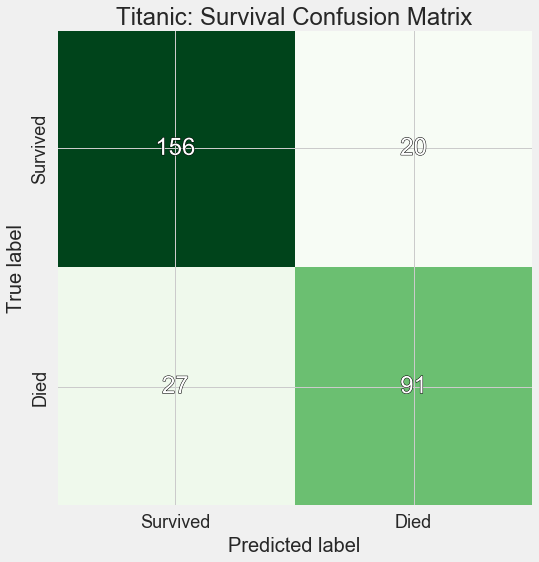

In [166]:
plot_confusion_matrix(cm, title='Titanic: Survival Confusion Matrix', \
                      labels=['Survived', 'Died'], cmap=plt.cm.Greens)

In [167]:
actual = pd.DataFrame(y_test)
predicted = pd.DataFrame(y_pred, columns = ['predicted'])
actual = actual.applymap(int)
predicted = predicted.applymap(int)

In [168]:
roc = roc_curve(actual, predicted)
roc

(array([ 0.        ,  0.11363636,  1.        ]),
 array([ 0.        ,  0.77118644,  1.        ]),
 array([2, 1, 0]))

In [169]:
pred1 = grid2.predict_proba(X2).T[1]

In [174]:
def getROCcurve(roc, title='ROC Curve', xlabel='% False Positives', ylabel='% True Positives'):
    fpr, tpr, thresholds = roc
    
    fig,ax = plt.subplots()
    ax.plot(fpr, tpr, label='ROC Curve')

    fig.set_size_inches(7, 6, forward=True)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
#    plt.legend(loc='best')
    plt.plot([0, 1], [0, 1], 'k--', linewidth = 0.4, color = 'magenta')
    return

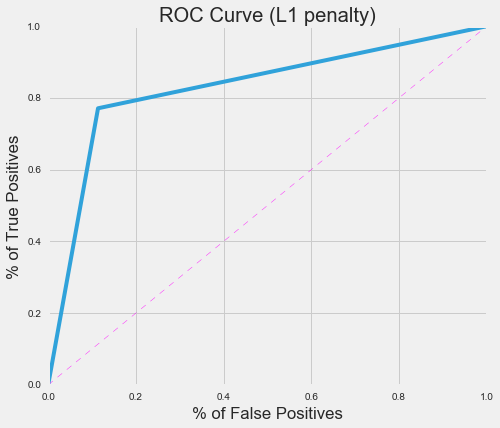

In [175]:
getROCcurve(roc, title='ROC Curve (L1 penalty)', xlabel ='% of False Positives', \
            ylabel = '% of True Positives')

In [172]:
print classification_report(actual, predicted)

             precision    recall  f1-score   support

          0       0.85      0.89      0.87       176
          1       0.82      0.77      0.79       118

avg / total       0.84      0.84      0.84       294

